In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [6]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


In [7]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Added color jittering
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# Set directories for training and test datasets
train_dir = '/Users/tishyakasliwal/Real_AI_SD_LD_Dataset/train/UkiyoE'  
test_dir = '/Users/tishyakasliwal/Real_AI_SD_LD_Dataset/test/UkiyoE'      

In [6]:
# Debugging: Check if the directories exist
import os 
print("Train directory exists:", os.path.exists(train_dir))
print("Test directory exists:", os.path.exists(test_dir))

Train directory exists: True
Test directory exists: True


In [7]:
# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)
test_dataset = ImageFolder(test_dir, transform=test_transforms)

In [8]:
# Print class mapping
print("Class to idx mapping:", train_dataset.class_to_idx)

Class to idx mapping: {'AI_LD_ukiyo-e': 0, 'AI_SD_ukiyo-e': 1, 'ukiyo_e': 2}


In [9]:
# Create data loaders - using full dataset since we now have fewer classes
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


Displaying first batch of images:


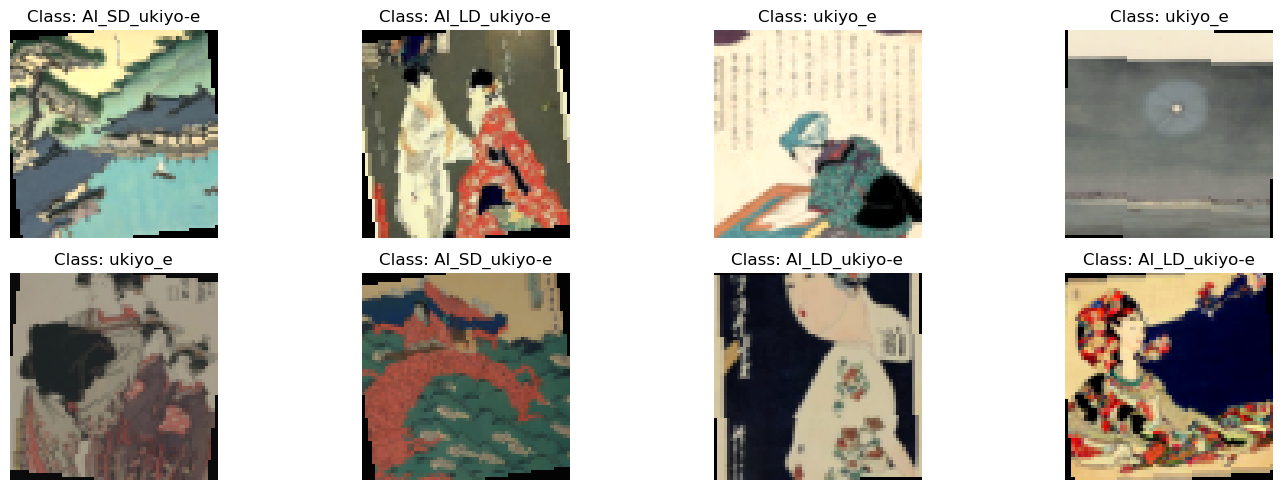

In [9]:
# Function to show images
def imshow_batch(images, labels, class_to_idx):
    plt.figure(figsize=(15, 5))
    
    # Create inverse mapping of class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    
    # Denormalize the images
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    images = images * std + mean  # denormalize
    images = torch.clamp(images, 0, 1)  # clamp to [0,1]
    
    # Show images
    for idx in range(min(8, len(images))):
        plt.subplot(2, 4, idx + 1)
        plt.imshow(images[idx].permute(1, 2, 0))
        plt.title(f'Class: {idx_to_class[labels[idx].item()]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Get a batch of training data and show it
dataiter = iter(train_loader)
images, labels = next(dataiter)
print("\nDisplaying first batch of images:")
imshow_batch(images, labels, train_dataset.class_to_idx)

In [5]:
# Modified CNN architecture for 3-class classification
class UkiyoeCNN(nn.Module):
    def __init__(self, num_classes=3):  # Changed to 3 classes
        super(UkiyoeCNN, self).__init__()
        
        self.features = nn.Sequential(
            # First convolution block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second convolution block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third convolution block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Fourth convolution block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Dropout(0.25),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  # Output layer changed to 3 classes
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [11]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=20):
    best_acc = 0.0
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Testing phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        class_correct = [0] * 3
        class_total = [0] * 3
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                # Per-class accuracy
                c = (predicted == labels).squeeze()
                for i in range(labels.size(0)):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
        
        test_loss = test_loss / len(test_loader)
        test_acc = 100. * correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        # Print per-class accuracy
        for i in range(3):
            if class_total[i] > 0:
                class_acc = 100 * class_correct[i] / class_total[i]
                print(f'Accuracy of class {i}: {class_acc:.2f}%')
        
        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_ukiyoe_classifier.pth')
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        print(f'Best Test Acc: {best_acc:.2f}%')
        print('-' * 60)
    
    return train_losses, test_losses, train_accuracies, test_accuracies


In [12]:
# Initialize model, loss function, and optimizer
model = UkiyoeCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [13]:
# Train the model
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=10
)

Epoch 1/10:   0%|          | 0/495 [00:00<?, ?it/s]

Accuracy of class 0: 96.60%
Accuracy of class 1: 98.80%
Accuracy of class 2: 91.50%
Epoch 1/10:
Train Loss: 0.2966, Train Acc: 90.82%
Test Loss: 0.1289, Test Acc: 95.63%
Best Test Acc: 95.63%
------------------------------------------------------------


Epoch 2/10:   0%|          | 0/495 [00:00<?, ?it/s]

Accuracy of class 0: 93.30%
Accuracy of class 1: 94.70%
Accuracy of class 2: 98.10%
Epoch 2/10:
Train Loss: 0.1540, Train Acc: 94.74%
Test Loss: 0.2273, Test Acc: 95.37%
Best Test Acc: 95.63%
------------------------------------------------------------


Epoch 3/10:   0%|          | 0/495 [00:00<?, ?it/s]

Accuracy of class 0: 97.70%
Accuracy of class 1: 99.40%
Accuracy of class 2: 95.90%
Epoch 3/10:
Train Loss: 0.1220, Train Acc: 95.90%
Test Loss: 0.0859, Test Acc: 97.67%
Best Test Acc: 97.67%
------------------------------------------------------------


Epoch 4/10:   0%|          | 0/495 [00:00<?, ?it/s]

Accuracy of class 0: 89.20%
Accuracy of class 1: 98.10%
Accuracy of class 2: 97.90%
Epoch 4/10:
Train Loss: 0.1140, Train Acc: 96.40%
Test Loss: 0.2066, Test Acc: 95.07%
Best Test Acc: 97.67%
------------------------------------------------------------


Epoch 5/10:   0%|          | 0/495 [00:00<?, ?it/s]

Accuracy of class 0: 97.00%
Accuracy of class 1: 99.80%
Accuracy of class 2: 95.60%
Epoch 5/10:
Train Loss: 0.1026, Train Acc: 96.84%
Test Loss: 0.1188, Test Acc: 97.47%
Best Test Acc: 97.67%
------------------------------------------------------------


Epoch 6/10:   0%|          | 0/495 [00:00<?, ?it/s]

Accuracy of class 0: 96.10%
Accuracy of class 1: 82.00%
Accuracy of class 2: 100.00%
Epoch 6/10:
Train Loss: 0.0922, Train Acc: 97.03%
Test Loss: 0.4091, Test Acc: 92.70%
Best Test Acc: 97.67%
------------------------------------------------------------


Epoch 7/10:   0%|          | 0/495 [00:00<?, ?it/s]

Accuracy of class 0: 90.90%
Accuracy of class 1: 94.60%
Accuracy of class 2: 99.80%
Epoch 7/10:
Train Loss: 0.0935, Train Acc: 97.14%
Test Loss: 0.2313, Test Acc: 95.10%
Best Test Acc: 97.67%
------------------------------------------------------------


Epoch 8/10:   0%|          | 0/495 [00:00<?, ?it/s]

Accuracy of class 0: 99.00%
Accuracy of class 1: 99.10%
Accuracy of class 2: 93.50%
Epoch 8/10:
Train Loss: 0.0976, Train Acc: 97.08%
Test Loss: 0.1710, Test Acc: 97.20%
Best Test Acc: 97.67%
------------------------------------------------------------


Epoch 9/10:   0%|          | 0/495 [00:00<?, ?it/s]

Accuracy of class 0: 97.30%
Accuracy of class 1: 98.30%
Accuracy of class 2: 98.70%
Epoch 9/10:
Train Loss: 0.0890, Train Acc: 97.24%
Test Loss: 0.1097, Test Acc: 98.10%
Best Test Acc: 98.10%
------------------------------------------------------------


Epoch 10/10:   0%|          | 0/495 [00:00<?, ?it/s]

Accuracy of class 0: 97.50%
Accuracy of class 1: 98.60%
Accuracy of class 2: 98.20%
Epoch 10/10:
Train Loss: 0.0690, Train Acc: 97.98%
Test Loss: 0.1239, Test Acc: 98.10%
Best Test Acc: 98.10%
------------------------------------------------------------


In [ ]:
# Plot training and testing curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Testing Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# Save the final model
torch.save(model.state_dict(), 'final_ukiyoe_classifier.pth')

In [11]:
# Instantiate your model
model = UkiyoeCNN()

# Load the state dictionary into your model
model.load_state_dict(torch.load('best_ukiyoe_classifier.pth'))

# Set the model to evaluation mode if you are using it for inference
model.eval()

/var/folders/2z/ssqbf1vd32x1pypcmcgd5k5m0000gn/T/ipykernel_54589/1673145124.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_ukiyoe

UkiyoeCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.25, inplace=False)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReL

/Users/tishyakasliwal/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


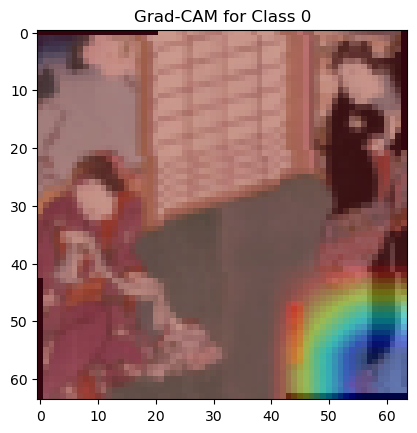

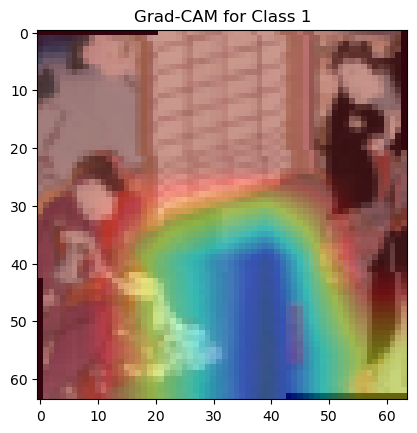

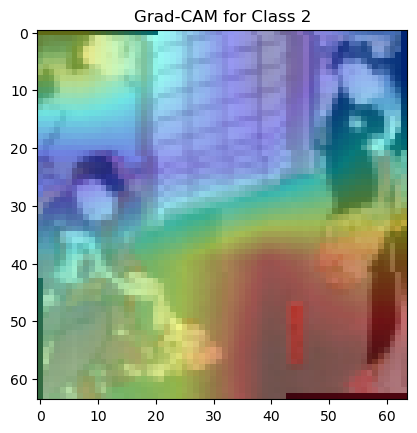

array([[[238, 255,  18],
        [238, 255,  18],
        [238, 255,  18],
        ...,
        [  0,  80, 255],
        [  0,  80, 255],
        [  0,  80, 255]],

       [[238, 255,  18],
        [238, 255,  18],
        [238, 255,  18],
        ...,
        [  0,  80, 255],
        [  0,  80, 255],
        [  0,  80, 255]],

       [[238, 255,  18],
        [238, 255,  18],
        [238, 255,  18],
        ...,
        [  0,  80, 255],
        [  0,  80, 255],
        [  0,  80, 255]],

       ...,

       [[130, 255, 126],
        [130, 255, 126],
        [130, 255, 126],
        ...,
        [188,   0,   0],
        [188,   0,   0],
        [188,   0,   0]],

       [[130, 255, 126],
        [130, 255, 126],
        [130, 255, 126],
        ...,
        [188,   0,   0],
        [188,   0,   0],
        [188,   0,   0]],

       [[130, 255, 126],
        [130, 255, 126],
        [130, 255, 126],
        ...,
        [188,   0,   0],
        [188,   0,   0],
        [188,   0,   0]]

In [164]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

def grad_cam(model, input_image, target_class, target_layer):
    model.eval()
    
    # Forward pass
    activation = None
    gradients = None

    def save_activation(module, input, output):
        nonlocal activation
        activation = output.detach()

    def save_gradient(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0].detach()

    # Register hooks
    target_layer.register_forward_hook(save_activation)
    target_layer.register_backward_hook(save_gradient)
    
    # Forward and backward pass
    input_image = input_image.unsqueeze(0)  # Add batch dimension
    output = model(input_image)
    model.zero_grad()
    class_loss = output[0, target_class]
    class_loss.backward()
    
    # Grad-CAM calculations
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activation.shape[1]):
        activation[:, i, :, :] *= pooled_gradients[i]
    
    heatmap = torch.mean(activation, dim=1).squeeze().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)  # Normalize
    
    # Convert heatmap to original image size
    heatmap = cv2.resize(heatmap, (input_image.shape[2], input_image.shape[3]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Overlay heatmap on original image
    img = input_image.squeeze().permute(1, 2, 0).cpu().numpy()
    img = img - img.min()
    img = img / img.max()
    img = np.uint8(255 * img)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    
    plt.imshow(overlay)
    plt.title(f"Grad-CAM for Class {target_class}")
    plt.show()

    return heatmap

input_image, _ = train_dataset[14001]  # Example image
grad_cam(model, input_image, target_class=0, target_layer=model.features[17])
grad_cam(model, input_image, target_class=1, target_layer=model.features[17])
grad_cam(model, input_image, target_class=2, target_layer=model.features[17])


Displaying image and its class label:


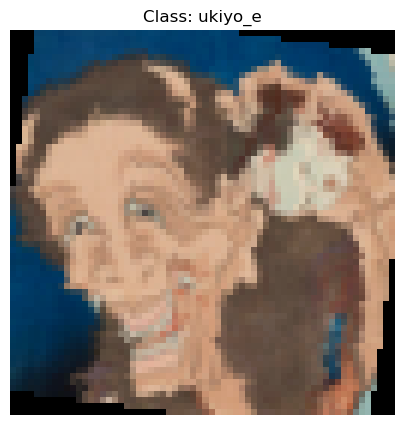

In [82]:
def imshow_single(image, label, class_to_idx):
    plt.figure(figsize=(5, 5))
    
    # Create inverse mapping of class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    
    # Denormalize the image
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    image = image * std + mean  # Denormalize
    image = torch.clamp(image, 0, 1)  # Clamp values to [0, 1]
    
    # Display the image
    plt.imshow(image.permute(1, 2, 0))  # Change dimensions to HWC for matplotlib
    plt.title(f'Class: {idx_to_class[label]}')
    plt.axis('off')
    plt.show()

# Get a single image and label
image, label = train_dataset[12000]  # Get the first image and label from the dataset
print(f"Displaying image and its class label:")
imshow_single(image, label, train_dataset.class_to_idx)


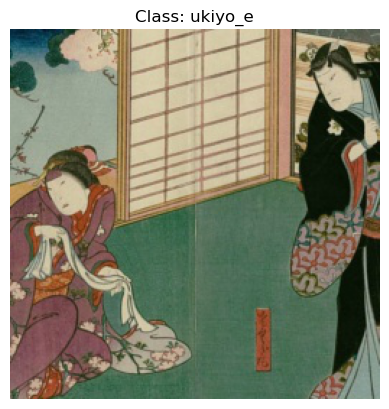

In [158]:
from PIL import Image
def show_raw_image(train_dir, dataset, idx):
    # Get the image path and corresponding label
    image_path, label = dataset.samples[idx]  # Accessing raw image path and label
    class_to_idx = dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}  # Inverse mapping
    
    # Open the image using PIL
    raw_image = Image.open(image_path)
    
    # Display the image and its class
    plt.imshow(raw_image)
    plt.title(f"Class: {idx_to_class[label]}")
    plt.axis("off")
    plt.show()

# Example usage
show_raw_image(train_dir, train_dataset, idx=14001) 

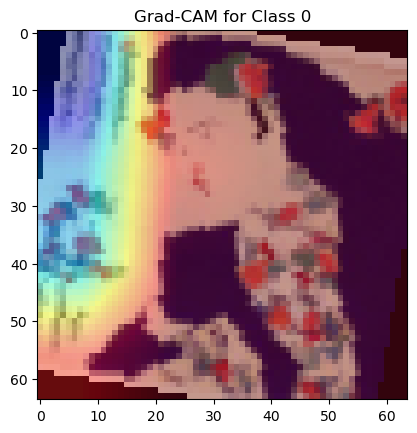

90.01996351576804


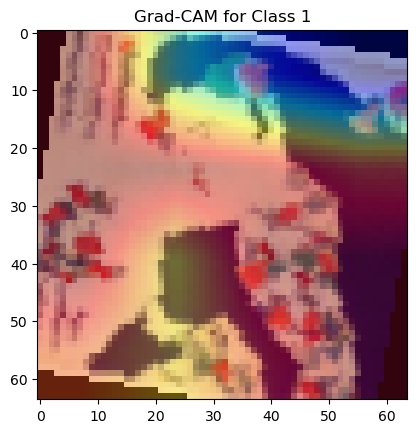

103.61141630561508


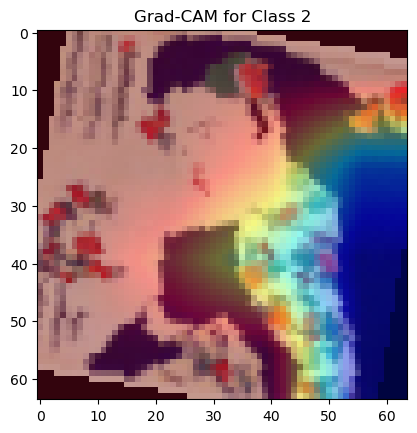

95.46283646905367


In [169]:
# Analyzing activation uniformity
def analyze_activation_uniformity(heatmap):
    
    # Calculate standard deviation of activation intensities
    uniformity_score = np.std(heatmap)
    return uniformity_score
    
# LD images should show lower standard deviation
# compared to SD images in early layers

input_image, _ = train_dataset[10]  # Example image
heatmap = grad_cam(model, input_image, target_class=0, target_layer=model.features[17])
print(analyze_activation_uniformity(heatmap))
heatmap1 = grad_cam(model, input_image, target_class=1, target_layer=model.features[17])
print(analyze_activation_uniformity(heatmap1))
heatmap2 = grad_cam(model, input_image, target_class=2, target_layer=model.features[17])
print(analyze_activation_uniformity(heatmap2))


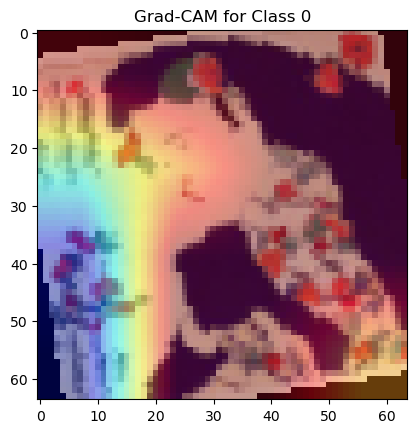

24.830654625810237


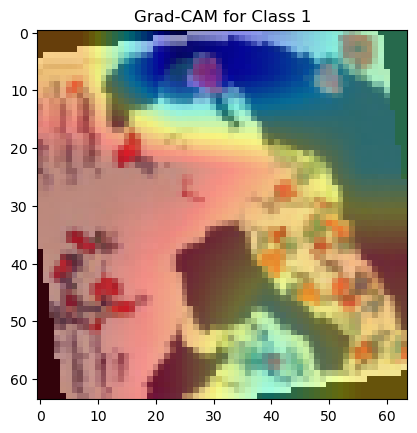

24.844536790623515


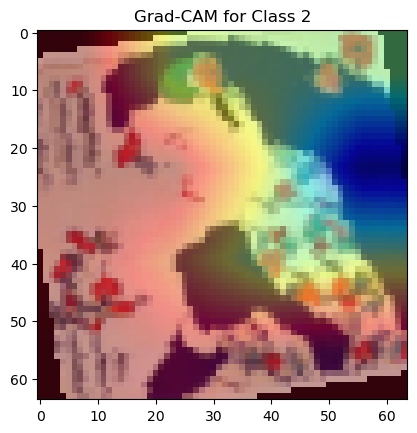

25.092564265632127


In [173]:
from scipy import ndimage
# Analyzing global activation patterns
def analyze_global_composition(heatmap):
    heatmap = np.mean(heatmap, axis=-1)  # Convert to grayscale
    height, width = heatmap.shape
    y,x = np.ogrid[:height, :width]
    # Calculate center of mass and distribution
    center_y, center_x = ndimage.center_of_mass(heatmap)
    distance_from_center = np.mean(np.sqrt((y - center_y)**2 + (x - center_x)**2))
    return distance_from_center
    
# LD images should show more centralized attention patterns
# compared to SD images in early layers

input_image, _ = train_dataset[10]  # Example image
heatmap = grad_cam(model, input_image, target_class=0, target_layer=model.features[17])
print(analyze_global_composition(heatmap))
heatmap1 = grad_cam(model, input_image, target_class=1, target_layer=model.features[17])
print(analyze_global_composition(heatmap1))
heatmap2 = grad_cam(model, input_image, target_class=2, target_layer=model.features[17])
print(analyze_global_composition(heatmap2))


In [7]:
import shap
PATH = "best_ukiyoe_classifier.pth"
model = UkiyoeCNN()
model.load_state_dict(torch.load(PATH, weights_only=True))
model.eval()

UkiyoeCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.25, inplace=False)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReL

In [8]:
# The plan with the SHAP values was to identify different categories that followed the Ukiyo-e art style
# for example, Ukiyo-e art style tends to follow a specific color palette, have thicker lines drawing the whole thing
# The following code only implements the color palette attribute (since our team decided to focus our time on GRAD-CAM instead)
# Using these attributes we are analyzing our results and feeding the input images to see what attributes are being focused on

def get_ukiyoe_palette():
    # These are some common colors used for the Ukiyo-e art style
    palette = np.array([
        [193, 39, 45],    # Vermillion red
        [236, 205, 66],   # Mustard yellow
        [79, 121, 66]    # Olive green
        # Was testing with these initially
    ], dtype=np.uint8)
    
    return palette

def compute_color_histogram(image):

    palette = get_ukiyoe_palette()
    hist = np.zeros(len(palette))
    
    for i, color in enumerate(palette):
        # Euclidean distance between pixels and palette color
        distances = np.linalg.norm(pixels - color, axis=1)
        # Count pixels within a threshold distance
        hist[i] = np.sum(distances < 30)  # Estimated guess
    # Normalize histogram
    hist /= np.sum(hist)
    return hist

def image_to_scalar(output_images):
    scalar_values = []
    ukiyoe_palette_hist = np.ones(len(get_ukiyoe_palette())) / len(get_ukiyoe_palette())
    for img in output_images:
        img_hist = compute_color_histogram(img)
        # Compute cosine similarity
        similarity = np.dot(img_hist, ukiyoe_palette_hist) / (np.linalg.norm(img_hist) * np.linalg.norm(ukiyoe_palette_hist))
        scalar_values.append(similarity)
    return np.array(scalar_values)

def model_scalar_output(input_data):
    scalar_output = image_to_scalar(input_data)
    return scalar_output

In [ ]:
# Didn't finish this part, was in the progress of debugging

dataiter = iter(train_loader)
images, labels = next(dataiter)

explainer = shap.KernelExplainer(model_scalar_output, background_data)
shap_values = explainer.shap_values(test_samples)

# explainer = shap.DeepExplainer(model_scalar_output, images)
# test_samples = input_images[0:5]
# shap_values = explainer.shap_values(test_samples)
# shap_values = shap_values[0]
shap.image_plot(shap_values, test_samples)